# `pyutils` multifile  

## Introduction 

This turorial is intended to show users how to handle multiple input files using `pyutils`, either using local file lists, remote file lists, and SAM definitions. We cover simple array-based processing and more complex custom processing.

## Table of contents
1. Simple processing
1. Complex processing & analysis with the `Skeleton` template class

## 1. Simple processing

The `process_data` function from `pyprocess` can be used to multithread processes on a list of EventNtuple files. This will work with both local and remote files. 

The default behaviour is to return the results as a single concatenated awkward array, which works well for small datasets. As will be discussed in example 3, you can customise the "process function" to run whatever job you need against each file. 

Remember to run `getToken` before trying this, otherwise you will see errors when loading the files. You should also ensure the files are prestaged (see Mu2e wiki).


In [ ]:
# Import the Processor class from pyprocess 
from pyutils.pyprocess import Processor 

# Initialise the Processor class instance
# If files are 
processor = Processor(
    use_remote = True, 
    location = "disk",
    verbosity = 2
)

# Define path to list of 10 local files
# "Local" means that each file name includes the full path to a location on a local disk, such as `/exp/data`. 
# file_list_path = "/exp/mu2e/data/users/sgrant/pyutils-demo/local_file_list.txt"
file_list_path = "/exp/mu2e/data/users/sgrant/pyutils-demo/remote_file_list.txt"

# Define branches
# Branches can also be defined as a list of a grouped dict of lists, depending on requirements
branches = [
    "event",
    "trk.nactive",
    "trkqual.result",
    "crvcoincs.PEs",
    "trksegs"
]

# Process the files using multithreading
data = processor.process_data(
    file_list_path = file_list_path, 
    # defname = defname, # Alternatively, you can provide a SAM definition
    branches = branches
)

[pyutils] [INFO] Setting up...
[pyutils] [OK] Ready
[pyprocess] [INFO] Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=2
[pyprocess] [INFO] Loading file list from remote_file_list.txt
[pyprocess] [OK] Successfully loaded file list
	Path: None
	Count: 10 files
[pyprocess] [INFO] Starting processing on 10 files with 10 threads


Processing: 100%|██████████████████████████████| 10/10 [00:06<00:00,  1.47file/s, successful=10, failed=0]

[pyprocess] [OK] Returning concatenated array containing 31800 events
[pyprocess] [DEBUG] Array structure:
31800 * {
    event: int32,
    "trk.nactive": var * int32,
    "trkqual.result": var * float32,
    "crvcoincs.PEs": var * float32,
    trksegs: var * var * struct[{
        mom: struct[{
            fCoordinates: struct[{
                fX: float32,
                fY: float32,
                fZ: float32
            }, parameters={"__record__": "ROOT::Math::Cartesian3D<float>"}]
        }, parameters={"__record__": "ROOT::Math::DisplacementVector3D<ROOT::Math::Cartesian3D<float>,ROOT::Math::DefaultCoordinateSystemTag>"}],
        pos: struct[{
            fCoordinates: struct[{
                fX: float32,
                fY: float32,
                fZ: float32
            }, parameters={"__record__": "ROOT::Math::Cartesian3D<float>"}]
        }, parameters={"__record__": "ROOT::Math::DisplacementVector3D<ROOT::Math::Cartesian3D<float>,ROOT::Math::DefaultCoordinateSystemTag>"

We now have a concatenated awkward array called `data` which can be used for analysis.

> **Note**: Be mindful of memory constraints with large datasets.

## 2. More complex analyses with the `Skeleton` template class
   
The `pyprocess` framework provides tools for complex processing on large datasets where simple array-based approaches become impractical due to memory constraints. The `Skeleton` processor class provides access to pre-written methods which leverage the tools in the main `Processor` class, limiting the amount of custom code required, while also providing the flexiblity to override methods as needed. 

In this example, we will learn how to use the Skeleton to accumulate histograms from multiple files. 

In [ ]:
# Import required external packages
import awkward as ak    
import hist

# Import the framework classes
from pyutils.pyprocess import Skeleton, Processor # The base Skeleton template class provides structure

# Create your custom processor class
# We inherit from Skeleton - this gives us many pre-built methods without writing extra code
class MyProcessor(Skeleton):
    """Your custom file processor 
    
    This class inherits from the Skeleton base class, which provides the 
    basic structure and methods withing the Processor framework 
    """
    
    def __init__(self):
        """Initialise your processor with specific configuration
        
        This method sets up all the parameters needed for this specific analysis.
        """
        # Call the parent class's __init__ method first
        # This ensures we have all the base functionality properly set up
        super().__init__()

        # Now override parameters from the Skeleton with the ones we need
        # Data selection configuration 
        self.defname = "nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020aw_perfect_v1_3_v06_06_00.root"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/pyutils-demo/remote_file_list.txt"
        
        self.branches = ["crvcoincs.PEs"]
        self.use_remote = True       # Use remote file 
        self.location = "disk"       # File location
        self.use_processes = True    # Use multiproccessing rather than multithreading, if more optimal
        self.max_workers = 48        # Limit the number of worker threads

        # Now add your own analysis-specific parameters 
        # Histogram configuration: 1000 bins ranging from 0 to 10000
        self.nbins = 1000         
        self.xmin = 0
        self.xmax = 10000
    
    # ==========================================
    # Define the core processing logic
    # ==========================================
    # This method overrides the parent class's process_file method
    # It will be called automatically for each file by the execute method
    def process_file(self, file_name):
        """Process a single ROOT file
        
        This method will be called for each file in our list.
        It extracts data, processes it, and returns a result.
        
        Args:
            file_name: Path to the ROOT file to process
            
        Returns:
            A tuple containing the histogram (counts and bin edges)
        """
        try:
            # Create a local Processor to extract data from this file
            # This uses the configuration parameters in our class
            worker_processor = Processor(
                use_remote=self.use_remote, # Use remote file via mdh
                location=self.location,     # File location
                verbosity=0                 # Reduce output in worker threads
            )

            
            # Process this file data and return an array
            data = worker_processor.process_data(
                file_name=file_name,
                branches=self.branches
            )
            
            # ---- Analysis ----
            # This can be written up in a seperate module and imported!
            
            # Create histogram object with hist
            # https://pypi.org/project/hist/
            my_hist = hist.Hist(
                hist.axis.Regular(self.nbins, self.xmin, self.xmax, name="PEs", label="PEs")
            )

            # Flatten the nested array 
            flat_data = ak.flatten(data["crvcoincs.PEs"], axis=None)
            
            # Fill the histogram
            my_hist.fill(flat_data) 
            
            # Return the histogram data
            # This will be appended to a list by the execute method
            return my_hist 
        
        except Exception as e:
            # Handle any errors that occur during processing
            print(f"Error processing {file_name}: {e}")
            return None

    def postprocess(self, results):
        """
        Run custom postprocessing on results, where
        results is the per file output of process list in a list
        """
        combined_hist = None
        
        # Check if we have results
        if not results:
            return None
        
        # Loop through all results
        for h in results: 
            # Add this histogram to the accumulated one
            if combined_hist is None: # First one
                combined_hist = h.copy() 
            else: # Following ones
                combined_hist += h # hist packages makes this easy
        
        return combined_hist # final output

# ==========================================
# Create and run the processor
# ==========================================
# Create an instance of our custom processor
my_processor = MyProcessor()

# Run the processor on all files
# The execute method comes from the Skeleton parent class
# It runs the parallelisation and postprocessing
my_hist = my_processor.execute()

[Skeleton] [INFO] Skeleton init
[Skeleton] [INFO] Starting analysis
[pyprocess] [INFO] Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=1
[pyprocess] [OK] Successfully loaded file list
	SAM definition: nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020aw_perfect_v1_3_v06_06_00.root
	Count: 822 files
[pyprocess] [INFO] Starting processing on 822 files with 48 processes


Processing: 100%|██████████████████████████████| 822/822 [01:37<00:00,  8.43file/s, successful=822, failed=0]

[pyprocess] [INFO] Returning 822 results
[Skeleton] [OK] Analysis complete


> **Note**: Be mindful of the number of maximum number worker threads when working on a shared machine. 

At this point, 'hists' contains the results from all processed files
You can now analyse, plot, or save these results

## Plot the results

[pyplot] [INFO] Initialised Plot with mu2e.mplstyle and verbosity = 1
	Wrote h1_PEs.png


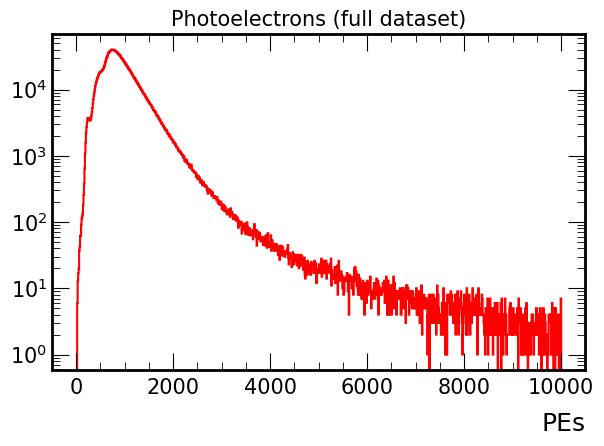

In [11]:
# Now plot
import matplotlib.pyplot as plt
from pyutils.pyplot import Plot
plotter = Plot()

fig, ax = plt.subplots()
my_hist.plot(flow=None)
ax.set_yscale("log")
ax.set_title("Photoelectrons (full dataset)")
plt.tight_layout()
out_name="h1_PEs.png"
plt.savefig(out_name)
print(f"\tWrote {out_name}")
plt.show()

> **Note**: I am not actually using using `pyplot` here, because at present it only works with flattened arrays, not histogram objects. However, initiliazing it gives access to the mu2e.mplstyle file.